In [148]:
import os

import cartopy.crs as ccrs
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pyproj as proj
import pandas as pd
from netCDF4 import Dataset  # pylint:disable=no-name-in-module
from shapely.geometry import Point

sf_type = 1
marker_size = 1

# Antarctica

In [149]:
nc = Dataset(
    os.path.join(
        os.environ["HOME"],
        "Documents",
        "eocis",
        "landice_dash_test",
        "data_files",
        "EOCIS-GIS-L3C-SEC-MULTIMISSION-5KM-5YEAR-MEANS-201001-201501-fv1.nc",
    )
)

In [150]:
for k, v in nc.variables.items():
    print(k, "\n", v)
    print()

sec 
 <class 'netCDF4._netCDF4.Variable'>
float32 sec(time_period, ny, nx)
    long_name: surface elevation change
    units: m/yr
    source: multi-mission radar altimetry
    grid_mapping: grid_projection
unlimited dimensions: 
current shape = (1, 620, 420)
filling on, default _FillValue of 9.969209968386869e+36 used

sec_uncertainty 
 <class 'netCDF4._netCDF4.Variable'>
float32 sec_uncertainty(time_period, ny, nx)
    long_name: uncertainty in surface elevation change
    units: m/yr
    grid_mapping: grid_projection
unlimited dimensions: 
current shape = (1, 620, 420)
filling on, default _FillValue of 9.969209968386869e+36 used

x 
 <class 'netCDF4._netCDF4.Variable'>
float32 x(nx)
    long_name: Cartesian x-coordinate - easting, of centre of each grid cell
    units: meters
    standard_name: projection_x_coordinate
    min_val: -997500.0
    binsize: 5000.0
unlimited dimensions: 
current shape = (420,)
filling on, default _FillValue of 9.969209968386869e+36 used

y 
 <class 'netC

In [151]:
nc["basin_id"][:].data.shape

(620, 420)

In [152]:
x_values: np.ndarray = nc["x"][:].data
y_values: np.ndarray = nc["y"][:].data
lat: np.ndarray = nc["lat"][:].data
lon: np.ndarray = nc["lon"][:].data
surf_type: np.ndarray = nc["surface_type"][:].data
sec: np.ndarray = np.squeeze(nc["sec"][:].data)

x_coords, y_coords = np.meshgrid(x_values, y_values, indexing="xy")

print(x_values.shape, y_values.shape)
print(x_coords.shape, y_coords.shape, sec.shape, surf_type.shape)

(420,) (620,)
(620, 420) (620, 420) (620, 420) (620, 420)


In [153]:
coords_arr = [Point(x, y) for x, y in zip(x_coords.flatten(), y_coords.flatten())]
sec_arr = sec.flatten()
surf_type_arr = surf_type.flatten()

print(len(coords_arr), sec_arr.shape, surf_type_arr.shape)

260400 (260400,) (260400,)


In [154]:
np.unique(surf_type)

array([0, 1, 2, 3, 4], dtype=int8)

In [155]:
my_data = gpd.GeoDataFrame(
    data={
        "SEC": sec_arr,
        "surface type": surf_type_arr,
        "geometry": coords_arr,
    },
    crs="epsg:3031",
)
my_data.head()

,SEC,surface type,geometry
0,NaN,0,POINT (-997500.000 -3497500.000)
1,NaN,0,POINT (-992500.000 -3497500.000)
2,NaN,0,POINT (-987500.000 -3497500.000)
3,NaN,0,POINT (-982500.000 -3497500.000)
4,NaN,0,POINT (-977500.000 -3497500.000)


In [156]:
sum(my_data["SEC"].isna())

208238

In [157]:
ais_basins = gpd.read_file("aux_files/IMBIE_AIS_Basins/ANT_Basins_IMBIE2_v1.6.shp")
ais_basins = (
    ais_basins.reset_index().rename(columns={"index": "basin_id"}).to_crs("epsg:4326")
)
ais_basins["basin_id"] = (ais_basins["basin_id"] + 1).astype(str)
ais_basins.head()

,basin_id,Regions,Subregion,geometry
0,1,Islands,None,"MULTIPOLYGON (((108.91949 -66.91047, 108.91933..."
1,2,West,H-Hp,"POLYGON ((-90.24588 -74.02074, -90.53000 -73.9..."
2,3,West,F-G,"POLYGON ((-144.36800 -75.62323, -144.36771 -75..."
3,4,East,E-Ep,"POLYGON ((-151.52291 -85.37243, -151.30170 -85..."
4,5,East,D-Dp,"POLYGON ((144.62895 -67.18320, 144.62074 -67.1..."


In [158]:
# crs_3031 = ccrs.Stereographic(central_latitude=-90, true_scale_latitude=-71)
# transformed = my_data.to_crs(crs_3031)

# fig, ax = plt.subplots(
#     figsize=(8, 6), facecolor="white", subplot_kw=dict(projection=crs_3031)
# )  # Create our plot

# transformed[transformed["SEC"].notna()].plot(
#     column="SEC",
#     ax=ax,
#     legend=True,
#     vmax=2,
#     vmin=-2,
#     marker="s",
#     markersize=marker_size,
#     cmap="bwr_r",
# )

# ais_basins.plot(color="none", edgecolor="black", ax=ax, alpha=0.5, lw=0.7)

# # ax.coastlines(resolution="50m", color="black")  # Add coastlines
# gl = ax.gridlines(draw_labels=True, color="black", alpha=0.25)
# gl.ylabel_style = {
#     "color": "black",
#     "alpha": 0.5,
# }
# ax.set_xlim(-2.8e6, 2.8e6)
# ax.set_ylim(-2.8e6, 2.8e6)

# fig.show()

In [159]:
timedata_ais = pd.read_csv(
    "/home/jgnq4/Documents/eocis/landice_dash_test/processed_files/time_series_data_AIS.csv"
).sort_values("code")

max_v_ais = np.round(timedata_ais["SEC"].abs().max(axis=None) + 0.05, 1)
timedata_ais = timedata_ais.reset_index(drop=True).reset_index()
timedata_ais["basin"] = timedata_ais["basin"].astype(str)
timedata_ais = pd.merge(
    timedata_ais,
    ais_basins[["basin_id", "Subregion"]],
    how="outer",
    left_on="basin",
    right_on="basin_id",
).drop(columns="basin_id")
timedata_ais.loc[timedata_ais["basin"] == "all", "Subregion"] = "All"
timedata_ais.loc[timedata_ais["basin"] == "0", "Subregion"] = "Outside Basins"
timedata_ais

,index,code,period,midpoint,basin,SEC,Subregion
0,0.0,199107-199607,1991/07 - 1996/07,1994.075928,0,-0.153539,Outside Basins
1,36.0,199108-199608,1991/08 - 1996/08,1994.160767,0,-0.164086,Outside Basins
2,55.0,199109-199609,1991/09 - 1996/09,1994.245605,0,-0.164086,Outside Basins
3,71.0,199110-199610,1991/10 - 1996/10,1994.327637,0,-0.164086,Outside Basins
4,98.0,199111-199611,1991/11 - 1996/11,1994.412476,0,-0.164086,Outside Basins
...,...,...,...,...,...,...,...
6536,6449.0,201805-202305,2018/05 - 2023/05,2020.908203,all,-0.004625,All
6537,6469.0,201806-202306,2018/06 - 2023/06,2020.993164,all,-0.004625,All
6538,6483.0,201807-202307,2018/07 - 2023/07,2021.075317,all,-0.004625,All
6539,6503.0,201808-202308,2018/08 - 2023/08,2021.160278,all,-0.004625,All


In [160]:
import altair as alt
import vl_convert as vlc
import json
from IPython.display import Image

alt.data_transformers.enable("vegafusion")

click_basin_ais = alt.selection_point(fields=["Subregion"])

map_ais = (
    alt.Chart(
        ais_basins,
    )
    .mark_geoshape()
    .encode(
        color=alt.Color("Subregion:N").legend(None),
        opacity=alt.condition(click_basin_ais, alt.value(1), alt.value(0.2)),
        tooltip=["basin_id:N", "Subregion:N", "Regions:N"],
    )
    .project(type="stereographic")
    .properties(width=300, height=300)
)

jchart1 = alt.JupyterChart(map_ais.add_params(click_basin_ais))
jchart1

JupyterChart(spec={'$schema': 'https://vega.github.io/schema/vega/v5.json', 'data': [{'name': 'param_14_store'…

In [161]:
# nearest = alt.selection_point(nearest=True, on="mouseover", fields=["index"], empty=False)

line_ais = (
    alt.Chart(timedata_ais, title="Mean SEC per Basin")
    .mark_line()
    .encode(
        alt.X("midpoint:Q", axis=alt.Axis(labels=False), title="Time Period"),
        alt.Y(
            "SEC:Q",
            scale=alt.Scale(domain=(-max_v_ais, max_v_ais)),
            title="Mean elevation change (m/year)",
        ),
        opacity=alt.condition(click_basin_ais, alt.value(1), alt.value(0.05)),
        color=alt.Color("Subregion:N").legend(None),
        tooltip=["SEC", "period", "Subregion"],
    )
    .properties(width=900, height=300)
)

# # Draw a rule at the location of the selection
# rules = base.mark_rule(color="gray").encode(
#     x="index:Q",
#     opacity=alt.condition(nearest, alt.value(1), alt.value(0)),
#     tooltip=[
#         alt.Tooltip("period", type="nominal", title="Time period"),
#     ],
# )

# points = line.mark_circle().encode(opacity=alt.condition(nearest, alt.value(1), alt.value(0)))

zero = pd.DataFrame([{"zero": 0.0}])
zero_rule = (
    alt.Chart(zero).mark_rule(color="black", strokeDash=[1]).encode(y="zero:Q", size=alt.value(1))
)

line_chart_ais = line_ais + zero_rule

jchart2 = alt.JupyterChart(line_chart_ais.add_params(click_basin_ais))
jchart2

JupyterChart(spec={'$schema': 'https://vega.github.io/schema/vega/v5.json', 'data': [{'name': 'param_14_store'…

In [162]:
chart = (map_ais | line_chart_ais).add_params(click_basin_ais)


jchart = alt.JupyterChart(chart)
jchart

JupyterChart(spec={'$schema': 'https://vega.github.io/schema/vega/v5.json', 'data': [{'name': 'param_14_store'…

# Greenland

In [163]:
nc = Dataset(
    os.path.join(
        os.environ["HOME"],
        "Documents",
        "eocis",
        "landice_dash_test",
        "data_files",
        "EOCIS-GIS-L3C-SEC-MULTIMISSION-5KM-5YEAR-MEANS-201001-201501-fv1.nc",
    )
)

In [164]:
for k, v in nc.variables.items():
    print(k, "\n", v)
    print()

sec 
 <class 'netCDF4._netCDF4.Variable'>
float32 sec(time_period, ny, nx)
    long_name: surface elevation change
    units: m/yr
    source: multi-mission radar altimetry
    grid_mapping: grid_projection
unlimited dimensions: 
current shape = (1, 620, 420)
filling on, default _FillValue of 9.969209968386869e+36 used

sec_uncertainty 
 <class 'netCDF4._netCDF4.Variable'>
float32 sec_uncertainty(time_period, ny, nx)
    long_name: uncertainty in surface elevation change
    units: m/yr
    grid_mapping: grid_projection
unlimited dimensions: 
current shape = (1, 620, 420)
filling on, default _FillValue of 9.969209968386869e+36 used

x 
 <class 'netCDF4._netCDF4.Variable'>
float32 x(nx)
    long_name: Cartesian x-coordinate - easting, of centre of each grid cell
    units: meters
    standard_name: projection_x_coordinate
    min_val: -997500.0
    binsize: 5000.0
unlimited dimensions: 
current shape = (420,)
filling on, default _FillValue of 9.969209968386869e+36 used

y 
 <class 'netC

In [165]:
x_values: np.ndarray = nc["x"][:].data
y_values: np.ndarray = nc["y"][:].data
lat: np.ndarray = nc["lat"][:].data
lon: np.ndarray = nc["lon"][:].data
surf_type: np.ndarray = nc["surface_type"][:].data
sec: np.ndarray = np.squeeze(nc["sec"][:].data)

x_coords, y_coords = np.meshgrid(x_values, y_values, indexing="xy")

print(x_values.shape, y_values.shape)
print(x_coords.shape, y_coords.shape, sec.shape, surf_type.shape)
print("X:", np.min(x_values), np.max(x_values))
print("Y:", np.min(y_values), np.max(y_values))

(420,) (620,)
(620, 420) (620, 420) (620, 420) (620, 420)
X: -997500.0 1097500.0
Y: -3497500.0 -402500.0


In [166]:
coords_arr = [Point(x, y) for x, y in zip(x_coords.flatten(), y_coords.flatten())]
sec_arr = sec.flatten()
surf_type_arr = surf_type.flatten()

print(len(coords_arr), sec_arr.shape, surf_type_arr.shape)

260400 (260400,) (260400,)


In [167]:
my_data = gpd.GeoDataFrame(
    data={
        "SEC": sec_arr,
        "surface type": surf_type_arr,
        "geometry": coords_arr,
    },
    crs="epsg:3413",
)
my_data.head()

,SEC,surface type,geometry
0,NaN,0,POINT (-997500.000 -3497500.000)
1,NaN,0,POINT (-992500.000 -3497500.000)
2,NaN,0,POINT (-987500.000 -3497500.000)
3,NaN,0,POINT (-982500.000 -3497500.000)
4,NaN,0,POINT (-977500.000 -3497500.000)


In [168]:
gis_basins = gpd.read_file("aux_files/IMBIE_GIS_Basins/Greenland_Basins_PS_v1.4.2.shp")
gis_basins = gis_basins.reset_index().rename(
    columns={"index": "basin_id", "SUBREGION1": "Subregion"}
)
gis_basins["basin_id"] = (gis_basins["basin_id"] + 1).astype(str)
gis_basins.head(10)

,basin_id,Subregion,NAME,GL_TYPE,geometry
0,1,CE,None,None,"POLYGON ((494674.033 -2296926.009, 494674.033 ..."
1,2,CW,None,None,"POLYGON ((-217099.792 -1995964.657, -217166.15..."
2,3,NO,None,None,"POLYGON ((-574414.723 -1154055.106, -578658.82..."
3,4,NE,None,None,"POLYGON ((433100.133 -1053500.305, 433159.304 ..."
4,5,NW,None,None,"POLYGON ((-250013.970 -1962482.806, -250392.42..."
5,6,SE,None,None,"POLYGON ((271743.988 -2648363.069, 271743.926 ..."
6,7,SW,None,None,"POLYGON ((-218031.425 -2376757.452, -216283.44..."


/tmp/ipykernel_28163/1794530712.py:31: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


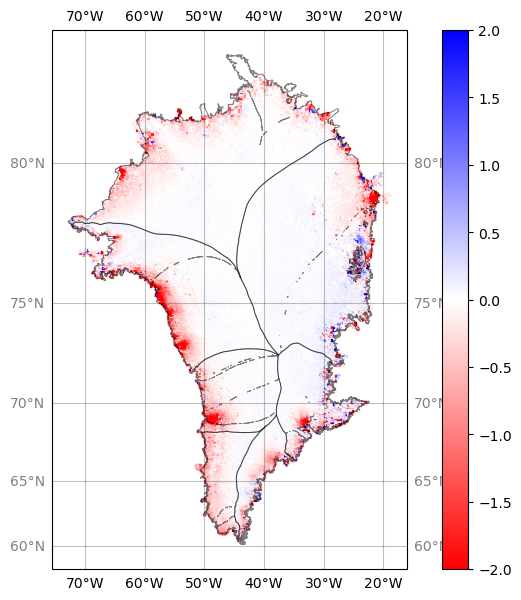

In [169]:
crs_new = ccrs.Mercator(central_longitude=42.6)
transformed = my_data.to_crs(crs_new)

fig, ax = plt.subplots(
    figsize=(9, 7), facecolor="white", subplot_kw=dict(projection=crs_new)
)  # Create our plot

transformed[transformed["SEC"].notna()].plot(
    column="SEC",
    ax=ax,
    legend=True,
    vmax=2,
    vmin=-2,
    marker="s",
    markersize=marker_size,
    cmap="bwr_r",
)

gis_basins.to_crs(crs_new).plot(color="none", edgecolor="black", ax=ax, alpha=0.5, lw=0.7)

gl = ax.gridlines(draw_labels=True, color="black", alpha=0.25)
gl.ylabel_style = {
    "color": "black",
    "alpha": 0.5,
}

ax.set_xlim(-13147697, -6536006)
ax.set_ylim(7930354, 17981513)


fig.show()

In [170]:
click_basin_gis = alt.selection_point(fields=["Subregion"])

map_gis = (
    alt.Chart(
        gis_basins.to_crs(epsg="4326"),
    )
    .mark_geoshape()
    .encode(
        color=alt.Color("Subregion:N"),
        opacity=alt.condition(click_basin_gis, alt.value(1), alt.value(0.2)),
        tooltip=["basin_id:N", "Subregion:N"],
    )
    .project("mercator")
)

jchart4 = alt.JupyterChart(map_gis.add_params(click_basin_gis), debounce_wait=1000)
jchart4

JupyterChart(debounce_wait=1000.0, spec={'$schema': 'https://vega.github.io/schema/vega/v5.json', 'data': [{'n…

In [171]:
timedata_gis = pd.read_csv(
    "/home/jgnq4/Documents/eocis/landice_dash_test/processed_files/time_series_data_GIS.csv"
).sort_values("code")

max_v_gis = np.round(timedata_gis["SEC"].abs().max(axis=None) + 0.05, 1)
timedata_gis = timedata_gis.reset_index(drop=True).reset_index()
timedata_gis["basin"] = timedata_gis["basin"].astype(str)
timedata_gis = pd.merge(
    timedata_gis,
    gis_basins[["basin_id", "Subregion"]],
    how="outer",
    left_on="basin",
    right_on="basin_id",
).drop(columns="basin_id")
timedata_gis.loc[timedata_gis["basin"] == "all", "Subregion"] = "All"
timedata_gis.loc[timedata_gis["basin"] == "0", "Subregion"] = "Outside"

timedata_gis

,index,code,period,midpoint,basin,SEC,Subregion
0,0,199107-199607,1991/07 - 1996/07,1994.075928,0,0.190743,Outside
1,16,199108-199608,1991/08 - 1996/08,1994.160767,0,0.205234,Outside
2,26,199109-199609,1991/09 - 1996/09,1994.245605,0,0.205234,Outside
3,34,199110-199610,1991/10 - 1996/10,1994.327637,0,0.205234,Outside
4,43,199111-199611,1991/11 - 1996/11,1994.412476,0,0.205234,Outside
...,...,...,...,...,...,...,...
2938,2902,201805-202305,2018/05 - 2023/05,2020.908203,all,-0.098539,All
2939,2907,201806-202306,2018/06 - 2023/06,2020.993164,all,-0.098539,All
2940,2916,201807-202307,2018/07 - 2023/07,2021.075317,all,-0.098539,All
2941,2925,201808-202308,2018/08 - 2023/08,2021.160278,all,-0.098539,All


In [172]:
max_v_gis

0.6

In [173]:
timedata_gis[timedata_gis["basin"] == "7"]

,index,code,period,midpoint,basin,SEC,Subregion
2289,7,199107-199607,1991/07 - 1996/07,1994.075928,7,0.032225,SW
2290,10,199108-199608,1991/08 - 1996/08,1994.160767,7,0.032225,SW
2291,20,199109-199609,1991/09 - 1996/09,1994.245605,7,0.032225,SW
2292,27,199110-199610,1991/10 - 1996/10,1994.327637,7,0.032225,SW
2293,37,199111-199611,1991/11 - 1996/11,1994.412476,7,0.032225,SW
...,...,...,...,...,...,...,...
2611,2898,201805-202305,2018/05 - 2023/05,2020.908203,7,-0.129848,SW
2612,2908,201806-202306,2018/06 - 2023/06,2020.993164,7,-0.129848,SW
2613,2917,201807-202307,2018/07 - 2023/07,2021.075317,7,-0.129848,SW
2614,2926,201808-202308,2018/08 - 2023/08,2021.160278,7,-0.129848,SW


In [174]:
line_gis = (
    alt.Chart(timedata_gis, title="Mean SEC per Basin")
    .mark_line()
    .encode(
        alt.X("midpoint:Q", axis=alt.Axis(labels=False), title="Time Period"),
        alt.Y(
            "SEC:Q",
            scale=alt.Scale(domain=(-max_v_gis, max_v_gis)),
            title="Mean elevation change (m/year)",
        ),
        opacity=alt.condition(click_basin_gis, alt.value(1), alt.value(0.05)),
        color=alt.Color("Subregion:N").legend(orient="left"),
        tooltip=["SEC", "period", "Subregion"],
    )
    .properties(width=900, height=300)
)

# # Draw a rule at the location of the selection
# rules = base.mark_rule(color="gray").encode(
#     x="index:Q",
#     opacity=alt.condition(nearest, alt.value(1), alt.value(0)),
#     tooltip=[
#         alt.Tooltip("period", type="nominal", title="Time period"),
#     ],
# )

# points = line.mark_circle().encode(opacity=alt.condition(nearest, alt.value(1), alt.value(0)))

zero = pd.DataFrame([{"zero": 0.0}])
zero_rule = (
    alt.Chart(zero).mark_rule(color="black", strokeDash=[1]).encode(y="zero:Q", size=alt.value(1))
)

line_chart_gis = line_gis + zero_rule

jchart4 = alt.JupyterChart(line_chart_gis.add_params(click_basin_gis))
jchart4

JupyterChart(spec={'$schema': 'https://vega.github.io/schema/vega/v5.json', 'data': [{'name': 'param_15_store'…

In [175]:
chart = (map_gis | line_chart_gis).add_params(click_basin_gis)


jchart = alt.JupyterChart(chart)
jchart

JupyterChart(spec={'$schema': 'https://vega.github.io/schema/vega/v5.json', 'data': [{'name': 'param_15_store'…